<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
categories = ['PNEUMONIA', 'NORMAL']
img_size = 224 

def get_images(dir): 
    images_array = []
    for category in categories: 
        path = os.path.join(dir, category)
        label = categories.index(category)
        for image in tqdm(os.listdir(path)): 
            try:
                img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # set image size 
                images_array.append([resized_arr, label])
            except Exception as e:
                print(e)
    return np.array(images_array)

train = get_images('/content/drive/MyDrive/Pneumonia/train')
test = get_images('/content/drive/MyDrive/Pneumonia/test')
val = get_images('/content/drive/MyDrive/Pneumonia/val')

100%|██████████| 1359/1359 [00:52<00:00, 26.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
100%|██████████| 8/8 [00:01<00:00,  4.36it/s]


## Exploratory analysis

###charts
- pneumonia vs normal 
- pneumonia type (bacteria vs virus) pie chart

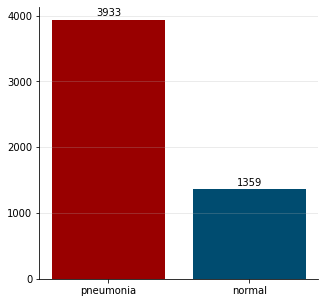

In [3]:
#@title
#pneumonia: label (0) & normal : label (1)
total_p = len(train[:, [1]]) - sum(train[:, [1]])
total_n = sum(train[:, [1]])
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(['pneumonia','normal'], [total_p[0], total_n[0]], color = ('#990000', '#004c70'))
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
for bar in ax.patches: 
  ax.annotate(f"{bar.get_height():.0f}", 
                   xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

# y-axis tick
grid_y_ticks = np.arange(0, 4400, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)

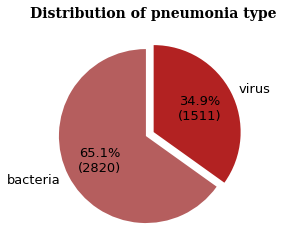

In [4]:
#@title 
train_dir = "/content/drive/MyDrive/Pneumonia/train/"
total_pneumonia_filenames = os.listdir(os.path.join(train_dir, 'PNEUMONIA')) 

virus_cnt, bacteria_cnt = 0, 0
for pneumonia_filename in total_pneumonia_filenames: 
  p_type = pneumonia_filename.split('_')[1]
  if p_type == "virus": 
    virus_cnt += 1
  elif p_type == "bacteria": 
    bacteria_cnt += 1

#distribution of pneumonia type - pie chart
y = [bacteria_cnt, virus_cnt]
labels = ["bacteria", "virus"]
colors = ['#b55e5e','#b22222']
myexplode = [0.1, 0]
def prob(x): 
  return '{:.1f}'.format(x) + '%' + "\n" + '(' + '{:.0f}'.format(x/100 * 4331) + ')'

plt.title("Distribution of pneumonia type", fontsize=14, fontweight='bold', fontfamily='serif')
plt.pie(y, labels=labels, startangle=90, colors=colors, explode=myexplode, autopct=prob, textprops={'fontsize': 13})
plt.show()

##show images
- pneumonia images
- normal images

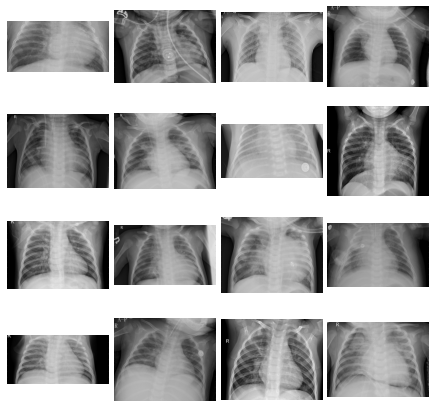

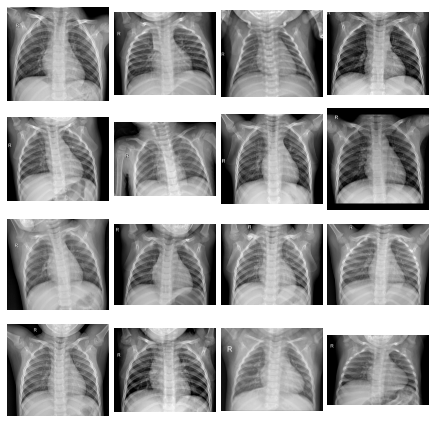

In [5]:
#@title
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 
  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = cv2.imread(os.path.join(os.path.join(dir, label), selected_images[i]))
    plt.imshow(image)
    plt.axis('off')
  plt.tight_layout(pad=0.5)
show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 
show_images(train_dir, label="NORMAL", size=4)

### Average image

In [6]:
#@title
def img_to_array(dir, label, size = (128,128)): #convert image to array to get mean pixel values
  image_array_list = []
  files = os.listdir(os.path.join(dir, label))
  for f in files: 
    file_path = os.path.join(os.path.join(dir, label), f)
    img = image.load_img(file_path, target_size = size, color_mode='grayscale')
    img_array = asarray(img).flatten()
    image_array_list.append(img_array)
  return image_array_list

p_imgs = img_to_array(train_dir, "PNEUMONIA")
n_imgs = img_to_array(train_dir, "NORMAL")

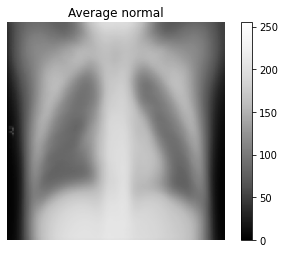

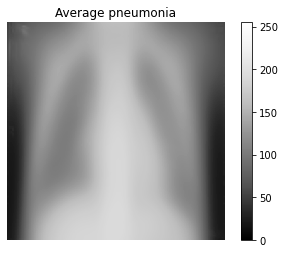

In [7]:
#@title
def average_img(images_list, label, size = (128,128)):
    # calculate the average
    avg_img = np.mean(images_list, axis = 0)
    # reshape
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='Greys_r', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()}')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return avg_img

norm_mean = average_img(n_imgs, 'NORMAL')
pneu_mean = average_img(p_imgs, 'PNEUMONIA')
#pneumonia X-rays tend to show higher obstruction around the chest area.

###Contrast

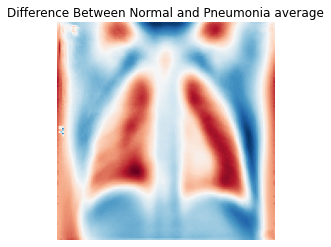

In [8]:
#@title
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='RdBu')
plt.title(f'Difference Between Normal and Pneumonia average')
plt.axis('off')
plt.show()
#red indicates the most different areas in dark color 
#blue indicates the most different areas in light color 

### Standard deviation 

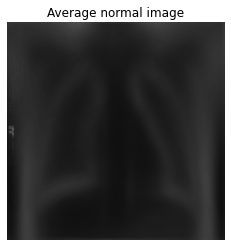

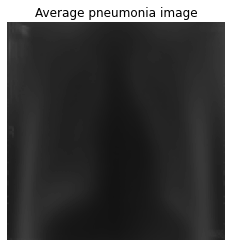

In [9]:
#@title
def std_img(images_list, label, size = (128,128)):
    # calculate the average
    avg_img = np.std(images_list, axis = 0)
    # reshape it back to a matrix
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='gray', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()} image')
    plt.axis('off')
    plt.show()
    return avg_img

norm_std = std_img(n_imgs, 'NORMAL')
pneu_std = std_img(p_imgs, 'PNEUMONIA')

#there are larger areas of variance found in pneumonia lung 

#Image preprocessing
- Augmentation with, without and balanced augmentation (oversampling normal data)

In [10]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for pixels, label in train:
    x_train.append(pixels)
    y_train.append(label)

for pixels, label in test:
    x_test.append(pixels)
    y_test.append(label)
    
for pixels, label in val:
    x_val.append(pixels)
    y_val.append(label)

# rescale
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for modeling
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [11]:
# datagen = ImageDataGenerator(
#         rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         shear_range = 0.1,
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = True)  # randomly flip images)  

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)
        # horizontal_flip = True)  # randomly flip images)  # randomly flip images

null_datagen = ImageDataGenerator()

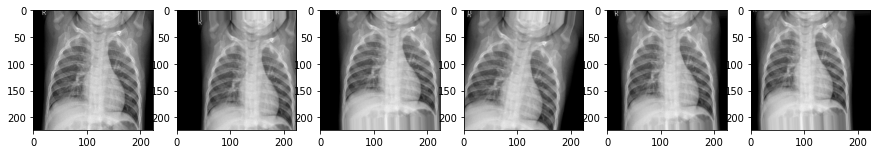

In [12]:
#augmented images of a sample image 
fig, axes = plt.subplots(1,6,figsize=(15,15))
axes[0].imshow(x_train[0][:,:,0], cmap='gray')
for i in range(5): 
  sample, label = datagen.flow(x_train[:1], y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')

In [26]:
#@title create_plot
def create_plot(history, epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [13]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32) 
steps_per_epoch = balanced_gen.steps_per_epoch #generated_image, label = train.__getitem__(18)
y_gen = [balanced_gen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True)) #number of each label changes every training *

(array([0, 1]), array([3919, 3921]))


In [14]:
#model 
def create_model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    return model
# model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [15]:
#with augmentation
model = create_model()
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) , epochs = 15 , validation_data =  null_datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Epoch 1/15
166/166 [==============================] - 39s 139ms/step - loss: 0.6514 - accuracy: 0.8566 - val_loss: 31.4304 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
166/166 [==============================] - 22s 135ms/step - loss: 0.2277 - accuracy: 0.9208 - val_loss: 32.1808 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
166/166 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9367
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 24s 145ms/step - loss: 0.1891 - accuracy: 0.9367 - val_loss: 34.5757 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
166/166 [==============================] - 22s 135ms/step - loss: 0.1204 - accuracy: 0.9620 - val_loss: 20.6802 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/15
166/166 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9605
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
166/166 [==================

In [ ]:
#@title 
# epochs = [i for i in range(12)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
# ax[1].set_title('Testing Accuracy & Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Training & Validation Loss")
# plt.show()

In [16]:
#balanced augmentation
model = create_model()
history = model.fit(balanced_gen, epochs = 20 , validation_data = null_datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Epoch 1/20
245/245 [==============================] - 37s 142ms/step - loss: 0.5355 - accuracy: 0.8708 - val_loss: 6.2362 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
245/245 [==============================] - 35s 140ms/step - loss: 0.2087 - accuracy: 0.9289 - val_loss: 19.9057 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
245/245 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9445
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
245/245 [==============================] - 35s 141ms/step - loss: 0.1777 - accuracy: 0.9445 - val_loss: 0.9815 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
245/245 [==============================] - 35s 142ms/step - loss: 0.1028 - accuracy: 0.9667 - val_loss: 13.7793 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/20
245/245 [==============================] - 36s 145ms/step - loss: 0.0914 - accuracy: 0.9712 - val_loss: 27.0468 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/20
245/245 [==================

In [ ]:
#@title 
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [18]:
#without augmentation
model = create_model()
history = model.fit(null_datagen.flow(x_train,y_train, batch_size = 32), epochs = 20 , validation_data = null_datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Epoch 1/20
166/166 [==============================] - 14s 75ms/step - loss: 0.5059 - accuracy: 0.8898 - val_loss: 21.3125 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - 12s 74ms/step - loss: 0.1527 - accuracy: 0.9537 - val_loss: 19.7732 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9677
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 12s 74ms/step - loss: 0.1072 - accuracy: 0.9677 - val_loss: 34.3073 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
166/166 [==============================] - 12s 75ms/step - loss: 0.0445 - accuracy: 0.9837 - val_loss: 3.5434 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/20
166/166 [==============================] - 12s 74ms/step - loss: 0.0304 - accuracy: 0.9904 - val_loss: 0.9245 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/20
166/166 [=======================

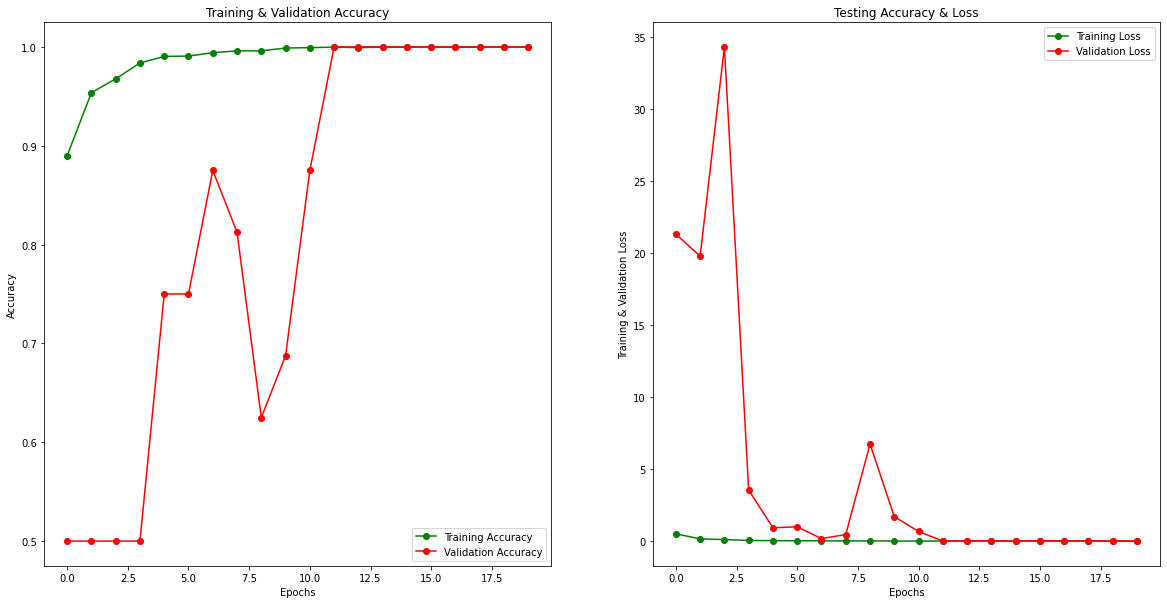

In [27]:
create_plot(history, 20)